### Through this notebook , I intend to present a small exploration of the genotype data colleced by the 100 Genomes prject based on the ethnicity of the smaples. 


    The data is downloaded from the ftp sever of thr 1000genomes project and consists of :
        ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz
            *this file contains a snp vs sample matrix [Genotype Matrix]
            *along with labels and meta info about the techniques and overall data
        affy_samples.20141118.panel
            *contains the information that helps us link the Genotype matrix to population codes
        20131219.populations.tsv
            *overall data about population code's and their ethnicities



In [1]:
#Import libraries needed for :

#datamanipulation and file processing
import pandas as pd
import allel 
from collections import defaultdict


#logging , downloding data ,decrypting  
import sys ,datetime
import ftplib 
import gzip

#statistics &preprocessing
from sklearn.decomposition import PCA as PCA
from sklearn.preprocessing import StandardScaler
import random

#plotting & visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#define the logging function
from __future__ import print_function

def log(msg,ID):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %T")
    logmsg = '[-- {} --] [{}]: {}'.format(timestamp,ID, msg)
    with open("log.txt","a") as f :
        f.write(logmsg+"\n")
    print(logmsg,file=sys.stderr)
server = 'ftp.1000genomes.ebi.ac.uk'

Connect to the ftp server and download the necessary files 

In [3]:
#connevt to server 
ftp = ftplib.FTP(server)
log("connecting to server","01")
ftp.login()


directory = '/vol1/ftp/phase3'
ftp.cwd(directory)
log('changing to directory : {}'.format(directory),'02')
ftp.retrlines('LIST')
population = '20131219.populations.tsv'
log('starting to download: {}'.format(population),'03')
ftp.retrbinary("RETR {}".format(population), open(population, 'wb').write)
log("finished download","04")


directory = '/vol1/ftp/release/20130502/supporting/hd_genotype_chip/'
ftp.cwd(directory)
log("changing to directoty : {}".format(directory),"05")
ftp.retrlines('LIST')

vcf = 'ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz'
log("starting to download: {}".format(vcf),"06")
ftp.retrbinary("RETR {}".format(vcf), open(vcf, 'wb').write)
log("finished download","07")

panel = 'affy_samples.20141118.panel'
ftp.retrbinary("RETR {}".format(panel), open(panel, 'wb').write)
log("finished download","08")

readme = 'README_Affy6_3450samples_merge.txt'
ftp.retrbinary("RETR {}".format(readme), open(readme, 'wb').write)
log("finished download","09")


ftp.quit()

[-- 2019-03-16 19:43:09 --] [01]: connecting to server
[-- 2019-03-16 19:43:10 --] [02]: changing to directory : /vol1/ftp/phase3


-r--r--r--    1 ftp      ftp      54743580 May 04  2015 20130502.phase3.analysis.sequence.index
-r--r--r--    1 ftp      ftp       3549051 May 04  2015 20130502.phase3.exome.alignment.index
-r--r--r--    1 ftp      ftp       3579471 May 04  2015 20130502.phase3.low_coverage.alignment.index
-r--r--r--    1 ftp      ftp      67057948 Nov 04  2015 20130502.phase3.sequence.index
-r--r--r--    1 ftp      ftp         25161 Jun 14  2015 20130725.phase3.cg_sra.index
-r--r--r--    1 ftp      ftp        471893 Jun 14  2015 20130820.phase3.cg_data_index
-r--r--r--    1 ftp      ftp          1663 Sep 16  2015 20131219.populations.tsv
-r--r--r--    1 ftp      ftp            97 Sep 16  2015 20131219.superpopulations.tsv
-r--r--r--    1 ftp      ftp           349 May 04  2015 README_20150504_phase3_data
-r--r--r--    1 ftp      ftp           536 Apr 04  2016 README_20160404_where_are_the_phase3_variants
dr-xr-xr-x    3 ftp      ftp          4096 Apr 30  2015 data
dr-xr-xr-x    3 ftp      ftp         

[-- 2019-03-16 19:43:10 --] [03]: starting to download: 20131219.populations.tsv
[-- 2019-03-16 19:43:11 --] [04]: finished download
[-- 2019-03-16 19:43:11 --] [05]: changing to directoty : /vol1/ftp/release/20130502/supporting/hd_genotype_chip/


-r--r--r--    1 ftp      ftp      1331157654 Sep 12  2014 ALL.chip.omni_broad_sanger_combined.20140818.snps.genotypes.vcf.gz
-r--r--r--    1 ftp      ftp       2285072 Sep 12  2014 ALL.chip.omni_broad_sanger_combined.20140818.snps.genotypes.vcf.gz.tbi
-r--r--r--    1 ftp      ftp      782884333 Oct 30  2014 ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz
-r--r--r--    1 ftp      ftp       2038827 Oct 30  2014 ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz.tbi
-r--r--r--    1 ftp      ftp      91341296 Oct 30  2014 ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_no_ped.vcf.gz
-r--r--r--    1 ftp      ftp       1550407 Oct 30  2014 ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_no_ped.vcf.gz.tbi
-r--r--r--    1 ftp      ftp          5329 Oct 30  2014 README_Affy6_3450samples_merge.txt
-r--r--r--    1 ftp      ftp          1605 Sep 12  2014 README_Omni25_2275samples_merge.txt
-r--r--r--    1 ftp      ftp         48322 Feb 20  2015 affy_samples.20141118.pane

[-- 2019-03-16 19:43:12 --] [06]: starting to download: ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz
[-- 2019-03-16 19:45:16 --] [07]: finished download
[-- 2019-03-16 19:45:17 --] [08]: finished download
[-- 2019-03-16 19:45:17 --] [09]: finished download


'221 Goodbye.'

In [4]:
"""
incase you have the files downloaded just runn the following cell instead
"""

population = '20131219.populations.tsv'
vcf = 'ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz'
panel = 'affy_samples.20141118.panel'



Now we need to read the downloaded data and prepare it for a PCA .


#https://github.com/cggh/scikit-allel/issues/45  is a good refernce for durther implementaion if sci-kit allel is to be used and of the data needs scaling 





In [5]:
#unpack tdownloaded data using sci-kit allel

log("starting loading data ","10")
vcf = allel.read_vcf(vcf,log=open("log.txt","a"))
log("finished loading","11")


#now we assemble the genotype matrix
genotype_matrix = allel.GenotypeArray(vcf["calldata/GT"])
log("assembled genotype matrix","12")


#this is the genotypy matrix in form rsids vs samples representing thier alleles
genotype_matrix = genotype_matrix.to_n_alt()

[-- 2019-03-16 19:45:18 --] [10]: starting loading data 
[-- 2019-03-16 19:50:52 --] [11]: finished loading
[-- 2019-03-16 19:50:52 --] [12]: assembled genotype matrix


In [6]:
#now we collect the supporting files to label the plot
#populations description file 
pop_dict = {}
pop_legend = {}


with open(population,"r") as f:
    lines= f.readlines()

for x,l in enumerate(lines):
    pop_dict[x] = l.split("\t")
    pop_legend[pop_dict[x][0]]=[pop_dict[x][1],pop_dict[x][2]]

populations_description = pd.DataFrame.from_dict(pop_dict,orient="index")

#now pannel file
pop_infile = defaultdict()

with open(panel,"r") as f :
    lines = f.readlines()

for x,l in enumerate(lines):
    pop_infile[l.strip("\n").split("\t")[0]]=l.strip("\n").split("\t")[1:]
population = pd.DataFrame.from_dict(pop_infile,orient="index")


populations_description = populations_description.rename(columns=populations_description.iloc[0])
population = population.rename(columns=population.iloc[0]).drop(population.index[0]).reset_index()



log("read and created supporting files","13")


#merge file keeping the relavant columns
population.rename(columns={'pop':'Population Code'}, inplace=True)
pop_legend = pd.merge(population,populations_description,on="Population Code")


#log the pairs of codes with their corresponding full names


#finally we save our matrix in data dataframe
data = pd.DataFrame(genotype_matrix,columns=pop_legend["Population Code"].tolist())

[-- 2019-03-16 19:52:32 --] [13]: read and created supporting files


In [7]:
#full matrix is read and trnasformed with each folumn for a sample
#print(data.shape)


legend = pop_legend.groupby(["Population Code","Population Description","Super Population"]).size().to_frame(name = 'count').reset_index()
log("the populations represented are : \n"+legend.sort_values(by="Super Population").reset_index(drop=True).to_string(),"14")

[-- 2019-03-16 19:52:36 --] [14]: the populations represented are : 
   Population Code                             Population Description Super Population  count
0              ACB                      African Caribbean in Barbados              AFR    122
1              MSL                              Mende in Sierra Leone              AFR    122
2              LWK                             Luhya in Webuye, Kenya              AFR    110
3              ESN                                    Esan in Nigeria              AFR    172
4              GWD            Gambian in Western Division, The Gambia              AFR    180
5              YRI                          Yoruba in Ibadan, Nigeria              AFR    182
6              ASW                   African Ancestry in Southwest US              AFR    107
7              PUR                        Puerto Rican in Puerto Rico              AMR    149
8              CLM                    Colombian in Medellin, Colombia              AM

In [8]:
"""

*considered adding some dada filtering methods but could not think of any as all the data is :
    *biallelic
    *and no snps have no calls in all the samples

    so, we can try and remove corelation by removing snps in LD using sci-kit allel
"""



log("finding ld and pruning data with size = 600 , step of 1000 and a threshold of 0.1","15")
loc_unlinked = allel.locate_unlinked(genotype_matrix, size=600, step=1000, threshold=.1)
n = np.count_nonzero(loc_unlinked)
n_remove = genotype_matrix.shape[0] - n
log('removing '+ str(n_remove)+' variants',"16")

[-- 2019-03-16 19:52:37 --] [15]: finding ld and pruning data with size = 600 , step of 1000 and a threshold of 0.1
[-- 2019-03-16 19:59:10 --] [16]: removing 431966 variants


### Now we perform a principal component analysis on the dataset "data" and produce plots.

    We use PCA implementation in sci-kit , this performs a SVD on the dataset , which when randomised , and seeded 
    appropriately gives us an equavalent and better suited output. 
        svd_solver   : for the large dataser we have , ranomly chooses wich reows and columns to remove for
                        the iteration
        random_state : random seed to start with
        iterated_power = number of iterations of the svd solver
        n_components = int of PC's to retain , top  5 
    
    We proceed to plot 2 pc's against each other .

In [9]:
%matplotlib inline


"""
original goal :
pca_full = PCA(svd_solver='randomized',random_state=randomseed,iterated_power="auto").fit(data)


but kernel restarts made me reconsider this approach ....
"""

sample = data.sample(frac=.02)
log("data too large to plot , random sample taken representing it (2%) ","17")
randomseed = random.randint(0,100)
pca_full = PCA(n_components = 5 ,random_state = randomseed).fit(sample.T)
#pca_full = PCA().fit(data)

[-- 2019-03-16 19:59:11 --] [17]: data too large to plot , random sample taken representing it (2%) 


In [10]:
log("PCA solver created with as "+str(pca_full),"18")

principalComponents = pca_full.fit_transform(sample.T)
log("PCA computed with components : " + str(principalComponents.shape[1]),"19")


#now we create a df with population infor for PC's
pca_toplot = pd.DataFrame(principalComponents,index=sample.T.index).reset_index()
pca_toplot.rename(columns={'index':'Population Code',0:"PC1",1:"PC2",2:"PC3",3:"PC5",4:"PC5"},inplace=True)
pca_toplot = pd.merge(legend,pca_toplot,on="Population Code")


log("The PC's computed and plotted are : \n"+pca_toplot.to_string(),"20")

[-- 2019-03-16 19:59:15 --] [18]: PCA solver created with as PCA(copy=True, iterated_power='auto', n_components=5, random_state=6,
  svd_solver='auto', tol=0.0, whiten=False)
[-- 2019-03-16 19:59:17 --] [19]: PCA computed with components : 5
[-- 2019-03-16 19:59:17 --] [20]: The PC's computed and plotted are : 
     Population Code                             Population Description Super Population  count        PC1        PC2        PC3        PC5        PC5
0                ACB                      African Caribbean in Barbados              AFR    122  39.880446   2.612652  -0.118133  -0.760190   8.456033
1                ACB                      African Caribbean in Barbados              AFR    122  39.380644   1.220288   0.472794   0.484682  11.646812
2                ACB                      African Caribbean in Barbados              AFR    122  39.233678   2.018244   0.594019   0.216069  12.203369
3                ACB                      African Caribbean in Barbados            

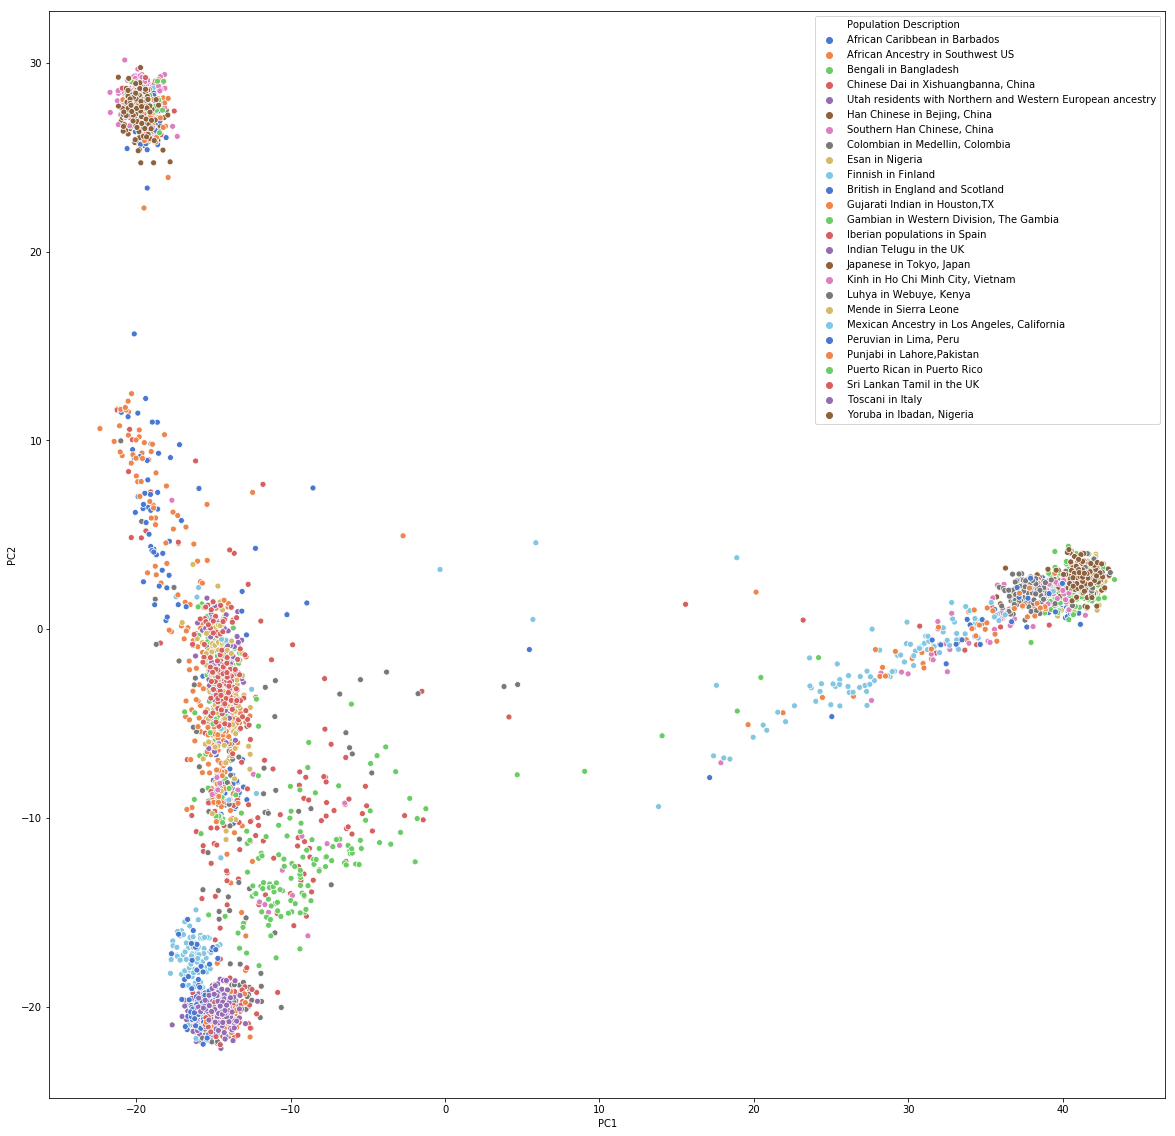

In [28]:
#specify palette
plt.gcf().set_size_inches(20, 20)
cmap = sns.color_palette("muted",n_colors=len(list(set(pca_toplot["Population Code"].str.cat(sep=",").split(",")))))
sns.scatterplot(pca_toplot["PC1"],pca_toplot["PC2"],hue =pca_toplot["Population Description"],palette=cmap)

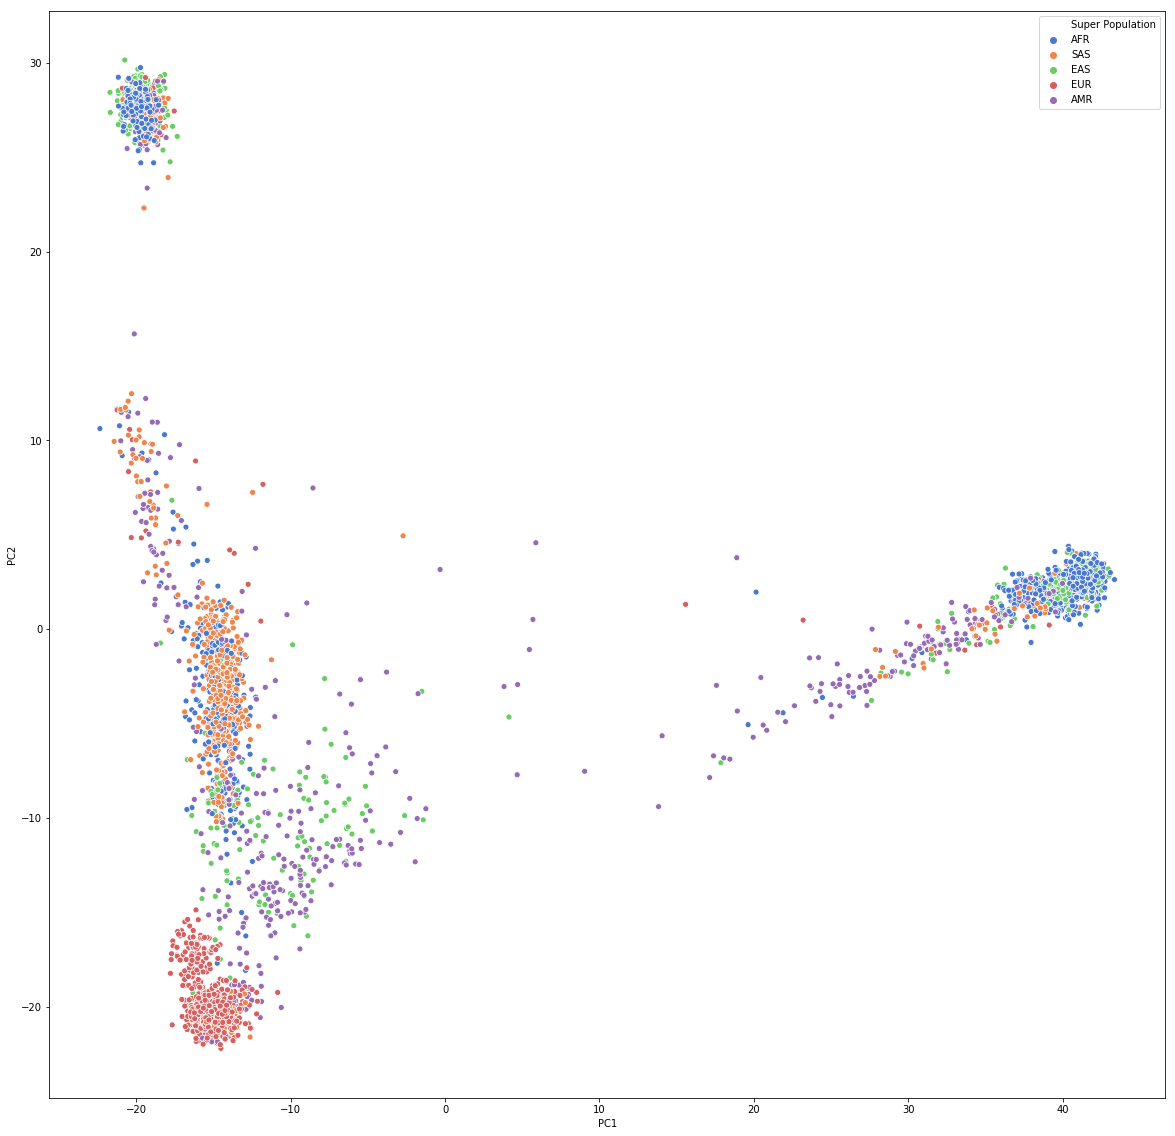

In [25]:
#plot2

cmap = sns.color_palette("muted",n_colors=len(list(set(pca_toplot["Super Population"].str.cat(sep=",").split(",")))))
plt.gcf().set_size_inches(20, 20)

sns.scatterplot(pca_toplot["PC1"],pca_toplot["PC2"],hue =pca_toplot["Super Population"],palette=cmap)

In [ ]:
log("process complete","-000-")






log()